In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [2]:

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f"Using device = {device}")

Using device = cpu


In [3]:
n_samples = 1000
X,y = make_circles(n_samples=1000, noise = 0.03, random_state=42)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (1000, 2)
Shape of y: (1000,)


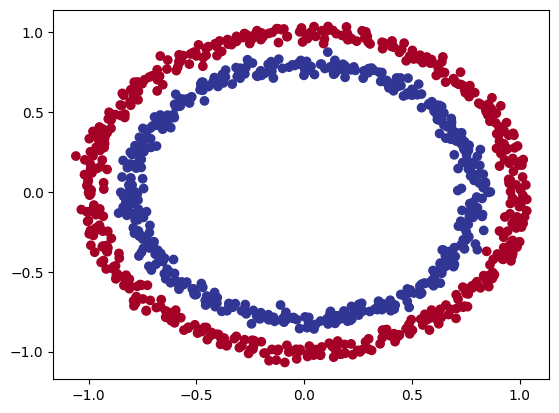

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap = 'RdYlBu')

In [5]:
X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
print("type of x:",type(X))
print("type of y:",type(y))

type of x: <class 'torch.Tensor'>
type of y: <class 'torch.Tensor'>


In [6]:
#splitting the training and testing dataset
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

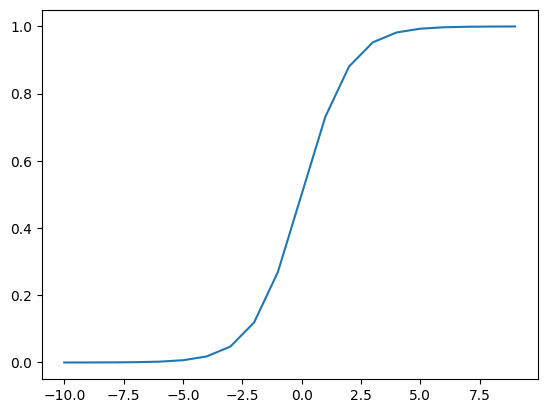

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

demo_x= range(-10, 10)
demo_y = [sigmoid(val) for val in demo_x]

plt.plot(demo_x, demo_y)


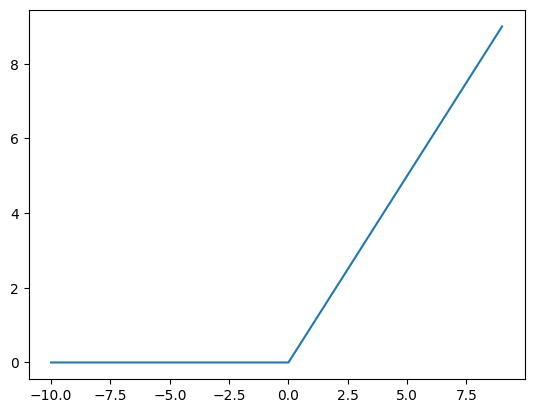

In [8]:
def relu(x):
    if x<=0:
        return 0
    else:
        return x


demo_x = range(-10, 10)
demo_y = [relu(val) for val in demo_x]

plt.plot(demo_x, demo_y)

In [9]:
class CircleClassifier(nn.Module):
    def __init__(self ,input_features,output_features, hidden_features=10):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_features)
        self.layer2 = nn.Linear(in_features=hidden_features,
                               out_features=hidden_features)
        self.layer3 = nn.Linear(in_features=hidden_features,
                               out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x:torch.Tensor)->torch.Tensor:
        x=self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))

        return self.layer3(x)

In [10]:
model_1 = CircleClassifier(input_features=2, output_features=1)
model_1.to(device)
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.1065, -0.4152],
                      [ 0.1230,  0.5562],
                      [-0.4412, -0.5657],
                      [ 0.3743,  0.1281],
                      [-0.2352, -0.0773],
                      [ 0.3558, -0.2680],
                      [ 0.6793,  0.1187],
                      [ 0.2514,  0.4969],
                      [ 0.3590,  0.1720],
                      [ 0.1496,  0.2131]])),
             ('layer1.bias',
              tensor([ 0.4995, -0.5318,  0.6943, -0.4366,  0.7031, -0.6878, -0.0368,  0.3620,
                      -0.0683, -0.3681])),
             ('layer2.weight',
              tensor([[-0.2864,  0.2352, -0.1190, -0.2934, -0.0692,  0.0852,  0.1003,  0.2787,
                       -0.1899, -0.2227],
                      [ 0.0727,  0.0010, -0.0360, -0.2738, -0.1823, -0.2883, -0.1568, -0.2769,
                       -0.0424,  0.2097],
                      [ 0.2156, -0.2139, -0.0370, -0.2637, -0.0622, -0.2681

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [23]:
from numpy import argmax


def accuracy_fn(y_true, y_pred):
    if y_pred.dim() == 1:  # Binary classification
        # Convert probabilities/logits to 0 or 1
        y_pred = (y_pred > 0.5).long()
    else:  # Multi-class classification
        y_pred = y_pred.argmax(dim=1)

    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [25]:
from tqdm import tqdm 
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
trainLossList = []
testLossList = []
for epoch in range(epochs):
    #training
    model_1.train()

    #forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #compute loss
    loss = loss_fn(y_logits, y_train)
    
    #zero grad optimizer
    optimizer.zero_grad()

    #back propagate
    loss.backward()

    #step the optimizer
    optimizer.step()
    # print(f"y_true shape: {y_train.shape}, y_pred shape: {y_pred.shape}")


    accuracy = accuracy_fn(y_true = y_train, y_pred=y_pred)

    #testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss  = loss_fn(test_logits, test_pred)
        test_accuracy = accuracy_fn(y_true = y_test, y_pred=test_pred)

    if(epoch%10==0):
        print(f"epoch:{epoch}|train loss:{loss:.5f}|test loss:{test_loss:.5f}")
    
    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

epoch:0|train loss:0.01078|test loss:0.02607
epoch:10|train loss:0.01071|test loss:0.02595
epoch:20|train loss:0.01063|test loss:0.02583
epoch:30|train loss:0.01055|test loss:0.02572
epoch:40|train loss:0.01047|test loss:0.02560
epoch:50|train loss:0.01040|test loss:0.02549
epoch:60|train loss:0.01033|test loss:0.02538
epoch:70|train loss:0.01025|test loss:0.02527
epoch:80|train loss:0.01018|test loss:0.02516
epoch:90|train loss:0.01011|test loss:0.02505
epoch:100|train loss:0.01004|test loss:0.02494
epoch:110|train loss:0.00997|test loss:0.02484
epoch:120|train loss:0.00990|test loss:0.02474
epoch:130|train loss:0.00984|test loss:0.02463
epoch:140|train loss:0.00977|test loss:0.02453
epoch:150|train loss:0.00971|test loss:0.02443
epoch:160|train loss:0.00964|test loss:0.02433
epoch:170|train loss:0.00958|test loss:0.02423
epoch:180|train loss:0.00951|test loss:0.02413
epoch:190|train loss:0.00945|test loss:0.02404
epoch:200|train loss:0.00939|test loss:0.02394
epoch:210|train loss:0.0

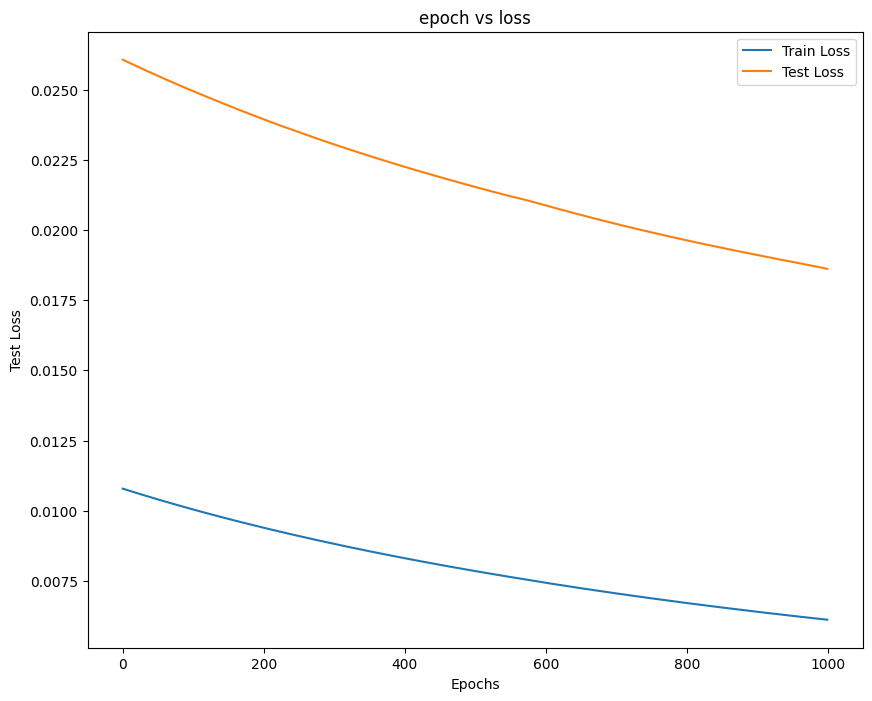

In [26]:
plt.figure(figsize=(10,8))
plt.plot(trainLossList, label="Train Loss")
plt.plot(testLossList, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('epoch vs loss')
plt.legend()

In [27]:

model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
print(y_preds)

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.])


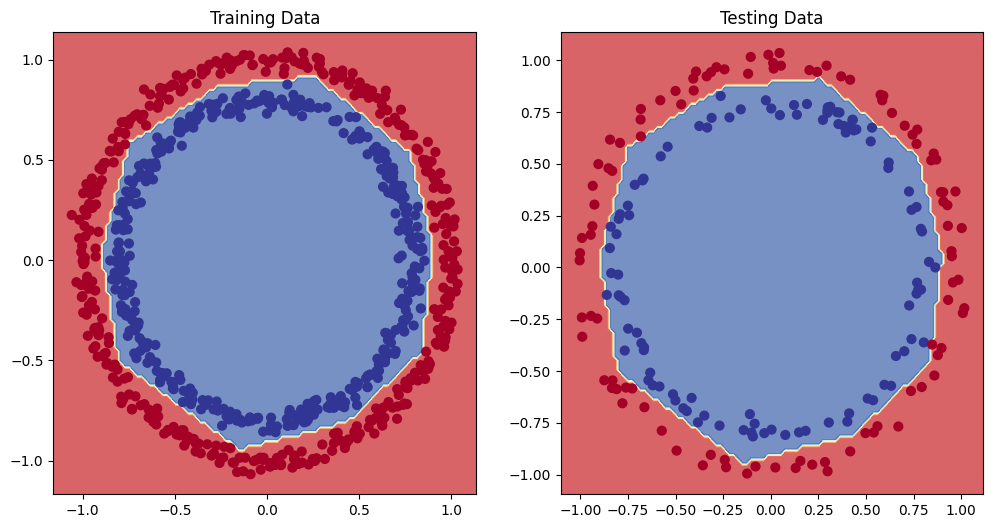

In [29]:

from helper_functions import plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing Data")
plot_decision_boundary(model_1, X_test, y_test)